In [ ]:
!pip install -q transformers torch pillow datasets

In [ ]:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth

In [ ]:
from unsloth import FastVisionModel
import torch

In [ ]:
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit"
]

In [ ]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth"
)

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True,
    finetune_language_layers=True,
    finetune_attention_modules=True,
    finetune_mlp_modules=True,

    r=16,
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    random_state = 3407,
    use_rslora=False,
    loftq_config=None
)

In [ ]:
from datasets import load_dataset
dataset1 = load_dataset("diptanu/im2latex-230k", split="train")

In [ ]:
def convert_to_conversation(sample):
  conversation = [
      {"role": "user",
       "content": [
           {"type": "text", "text": instruction},
           {"type": "image", "image": sample["image"]}
       ]
       },
      {"role": "assistant",
       "content": [
           {"type": "text", "text": sample["text"]}
       ]
       }
  ]
  return {"messages": conversation}

In [ ]:
from unsloth import FastVisionModel
import torch
from datasets import load_dataset
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth

fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit"
]
#
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth"
)
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True,
    finetune_language_layers=True,
    finetune_attention_modules=True,
    finetune_mlp_modules=True,

    r=16,
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    random_state = 3407,
    use_rslora=False,
    loftq_config=None
)
dataset1 = load_dataset("diptanu/im2latex-230k", split="train")
dataset1
dataset = dataset1.select(range(184000))
dataset
dataset[0]
dataset[0]["image"]
dataset[1]["image"]
dataset[1]["formula"]
instruction = "Write the LaTex representation for this image."
def convert_to_conversation(sample):
  conversation = [
      {"role": "user",
       "content": [
           {"type": "text", "text": instruction},
           {"type": "image", "image": sample["image"]}
       ]
       },
      {"role": "assistant",
       "content": [
           {"type": "text", "text": sample["formula"]} # Changed sample["text"] to sample["formula"]
       ]
       }
  ]
  return {"messages": conversation}

In [ ]:
def convert_to_conversation(sample):
  conversation = [
      {"role": "user",
       "content": [
           {"type": "text", "text": instruction},  # Assuming 'instruction' is defined elsewhere
           {"type": "image", "image": sample["image"].resize((224, 224))}  # Assuming 'image' is PIL Image
       ]
       },
      {"role": "assistant",
       "content": [
           {"type": "text", "text": sample["formula"]}  # Accessing the 'formula' feature
       ]
       }
  ]
  return {"messages": conversation}

In [ ]:
FastVisionModel.for_inference(model)

In [ ]:
image = dataset[1]["image"]
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": instruction},
            {"type": "image", "image": image}
        ]
    }
]

In [ ]:
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image, input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

In [ ]:
from transformers import TextStreamer #genarted latex
text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(**inputs, streamer= text_streamer, max_new_tokens = 128, use_cache=True, temperature=1.5, min_p=0.1)

In [ ]:
from transformers import NougatProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests
from io import BytesIO

# Load model and processor
model_id = "Norm/nougat-latex-base"
processor = NougatProcessor.from_pretrained(model_id)
model = VisionEncoderDecoderModel.from_pretrained(model_id)

# Move to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    224,
    560
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "use_absolute_embeddings": false,
  "window_size": 7
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0): DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )

In [ ]:
trainer = SFTTrainer(
    model = model,
    tokenizer=tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps = 5,
        max_steps=30,
        learning_rate=2e-4,
        fp16=not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to = "none",
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc=4,
        max_seq_length=2048,
    ),
)

In [ ]:
trainer.train()

In [ ]:
FastVisionModel.for_inference(model)

In [ ]:
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

In [ ]:
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True)

latex = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128, use_cache=True, temperature=1.5, min_p=0.1)

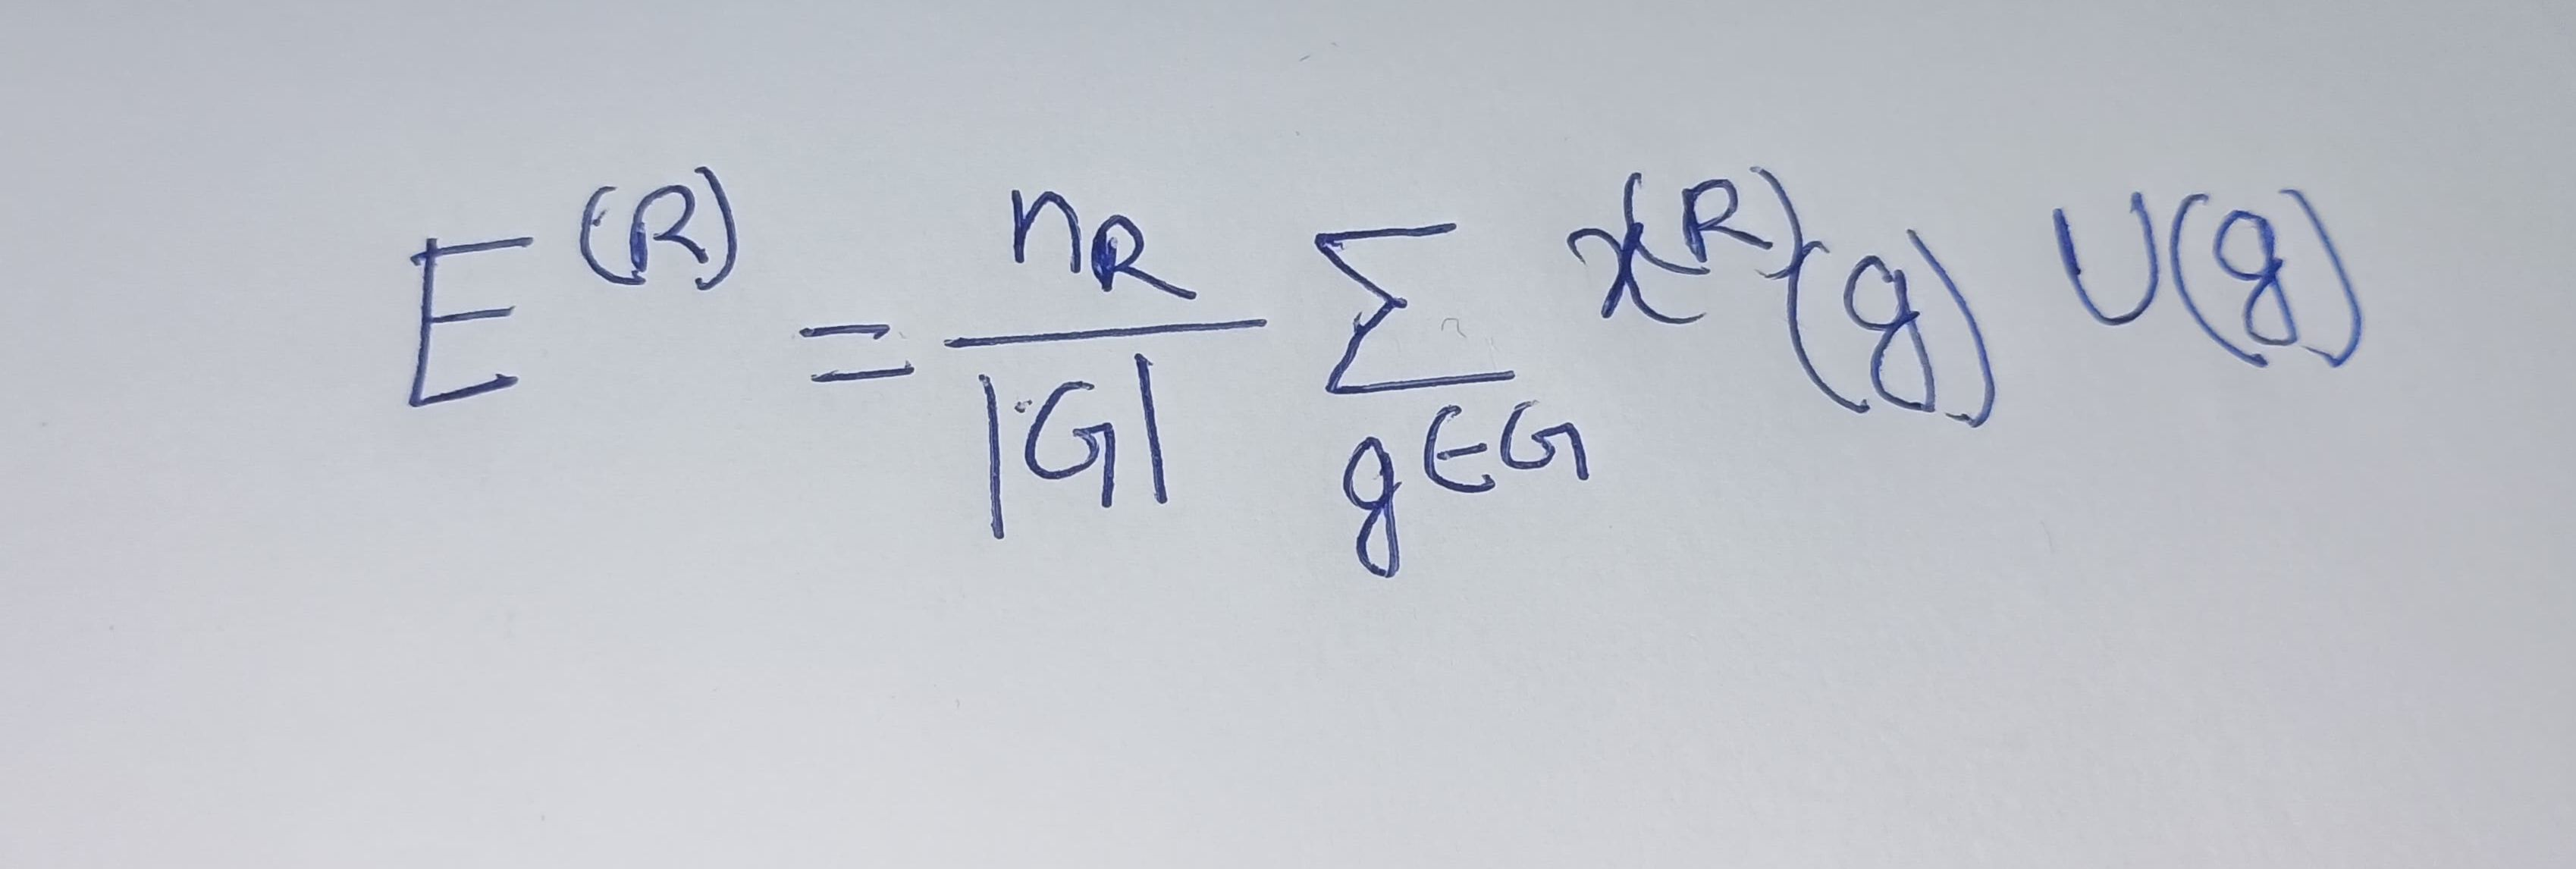

In [ ]:
image = Image.open("image.jpg").convert("RGB")
display(image)

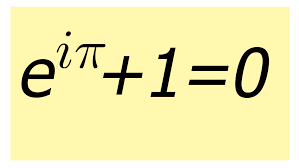

In [ ]:
image = Image.open("ei.png").convert("RGB")
display(image)

In [ ]:

pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
outputs = model.generate(
    pixel_values,
    max_new_tokens=512,
    early_stopping=True
)

# Decode output
latex_code = processor.batch_decode(outputs, skip_special_tokens=True)[0]
print("Generated LaTeX:\n", latex_code)

Generated LaTeX:
 {\Theta}^{i\pi}\!\!+\!{\cal I}=\!\!0\,
